### environment
* non gpu
* tensorflow==2.2.0
* opencv==4.3.0

# 1. import packages

In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import cv2
from matplotlib import pyplot as plt

import os
from datetime import datetime

In [2]:
np.__version__, tf.__version__, cv2.__version__

('1.19.0', '2.2.0', '4.3.0')

# 2. load video for prediction

In [3]:
video_path = './test_video/1.mp4'

In [4]:
predict_video = cv2.VideoCapture(video_path)
# predict_video = cv2.VideoCapture(0) # 0: default camera

width = predict_video.get(cv2.CAP_PROP_FRAME_WIDTH)
height = predict_video.get(cv2.CAP_PROP_FRAME_HEIGHT)
fps = predict_video.get(cv2.CAP_PROP_FPS)

print('%d*%d, %dfps' %(width, height, fps))

640*360, 25fps


In [5]:
%%time
predict_frame = np.empty((0, int(height), int(width), 3), dtype=float)

while predict_video.isOpened():
    ret, frame = predict_video.read()
    
    if not ret:
        print("frame cannot be received no more")
        break
    
    frame_to_np = np.expand_dims(np.array(frame), axis=0)
    predict_frame = np.append(predict_frame, frame_to_np, axis=0)

predict_frame.shape

frame cannot be received no more
CPU times: user 2min 20s, sys: 1min 53s, total: 4min 14s
Wall time: 4min 16s


(375, 360, 640, 3)

In [6]:
predict_video.release()

<function matplotlib.pyplot.show(*args, **kw)>

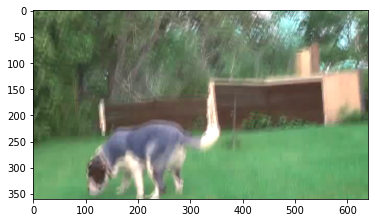

In [7]:
frame_num = 0
plt.imshow(predict_frame[frame_num].astype('int'))
plt.show

# 3. load saved model & predict

### 1. define function for pose prediction
refer function of deeplabcut

In [8]:
def load_model(saved_model_path):
    loaded = tf.saved_model.load(saved_model_path)
    infer = loaded.signatures["serving_default"]
    print(infer.structured_outputs)
    
    return infer

In [9]:
def extract_cnn_output(outputs_np, locref_stdev):
    scmap = np.squeeze(outputs_np[0])
    locref = np.squeeze(outputs_np[1])
    shape = locref.shape
    locref = np.reshape(locref, (shape[0], shape[1], -1, 2))
    locref *= locref_stdev
    
    return scmap, locref

In [10]:
def get_top_values(scmap):
    batchsize, ny, nx, num_joints = scmap.shape
    scmap_flat = scmap.reshape(batchsize, nx * ny, num_joints)
    scmap_top = np.argmax(scmap_flat, axis=1)[None]
    Y, X = np.unravel_index(scmap_top, (ny, nx))
    return Y, X

In [11]:
def multi_pose_predict(scmap, locref, stride):
    Y, X = get_top_values(scmap[None])
    Y, X = Y[:, 0], X[:, 0]
    num_joints = scmap.shape[2]
    DZ = np.zeros((1, num_joints, 3))
    for k in range(num_joints):
        x = X[0, k]
        y = Y[0, k]
        DZ[0, k, :2] = locref[y, x, k, :]
        DZ[0, k, 2] = scmap[y, x, k]

    X = X.astype("float32") * stride + 0.5 * stride + DZ[:, :, 0]
    Y = Y.astype("float32") * stride + 0.5 * stride + DZ[:, :, 1]
    P = DZ[:, :, 2]
    
    pose = np.empty((num_joints, 3), dtype="float32")
    pose[:, 0::3] = X.T
    pose[:, 1::3] = Y.T
    pose[:, 2::3] = P.T

    return pose

In [12]:
def predict_dog_pose(infer, predict_image):
    preds = infer(tf.constant(predict_image, dtype=tf.float32))
    
    result = []
    result.append(preds['Sigmoid'].numpy())
    result.append(preds['pose/locref_pred/block4/BiasAdd'].numpy())
    
    locref_stdef = 7.2801
    stride = 8.0
    
    scmap, locref = extract_cnn_output(result, locref_stdef)
    pose = multi_pose_predict(scmap, locref, stride)
    
    return pose

### 2. predict frame-by-frame

In [13]:
saved_model_path = './saved_model/'
infer = load_model(saved_model_path)

{'Sigmoid': <tf.Tensor 'Sigmoid:0' shape=(None, None, None, 20) dtype=float32>, 'pose/locref_pred/block4/BiasAdd': <tf.Tensor 'pose/locref_pred/block4/BiasAdd:0' shape=(None, None, None, 40) dtype=float32>}


In [14]:
# labeling
bodyparts = [
    'Nose',
    'L_Eye',
    'R_Eye',
    'L_Ear',
    'R_Ear',
    'Throat',
    'Withers',
    'TailSet',
    'L_F_Paw',
    'R_F_Paw',
    'L_F_Wrist',
    'R_F_Wrist',
    'L_F_Elbow',
    'R_F_Elbow',
    'L_B_Paw',
    'R_B_Paw',
    'L_B_Hock',
    'R_B_Hock',
    'L_B_Stiffle',
    'R_B_Stiffle'
]

skeleton = [
    [[0, 3], [3, 4], [4, 5], [0, 5]], # head
    [[5, 6]], # throat
    [[6, 7]], # back
    [[8, 10], [10, 12], [6, 12]], # left front leg
    [[9, 11], [11, 13], [13, 6]], # right front leg
    [[14, 16], [16, 18], [18, 7]], # left back leg
    [[15, 17], [17, 19], [19, 7]], # right back leg
]

In [15]:
%%time
pose = np.empty((0, len(bodyparts), 3), dtype=float)

for index in range(len(predict_frame)):
    pose_for_frame = predict_dog_pose(infer, predict_frame[index])
    pose_for_frame = np.expand_dims(pose_for_frame, axis=0)
    pose = np.append(pose, pose_for_frame, axis=0)
    
pose.shape

CPU times: user 9min 38s, sys: 1min 37s, total: 11min 16s
Wall time: 1min 22s


(375, 20, 3)

### 3. draw pose on frame

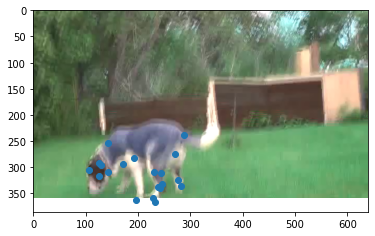

In [16]:
frame_num = 0
plt.imshow(predict_frame[frame_num].astype('int'))
plt_x = pose[frame_num, :, 0]
plt_y = pose[frame_num, :, 1]
plt.scatter(plt_x, plt_y)
plt.show()

# 4. draw pose on video

### 1. define function for drawing pose

In [17]:
def draw_pose(image, pose, skeleton, likelihood=0.0, dot_size=10, line_size=5):
    np.random.seed(0)
    dot_color = np.random.randint(256, size=(len(pose), 3))
    dot_color = dot_color.tolist()
    line_color = np.random.randint(256, size=(len(skeleton), 3))
    line_color = line_color.tolist()

    has_likelihood = []
    
    # dot
    for index in range(len(pose)):
        if pose[index, 2] >= likelihood:
            has_likelihood.append(True)
            x, y = round(pose[index, 0]), round(pose[index, 1])
            image = cv2.line(image, (x, y), (x, y), dot_color[index], dot_size)
        else:
            has_likelihood.append(False)
    
    # line
    for index, i in enumerate(skeleton):
        unique_index = np.unique(np.array(i).flatten())
        if False not in [has_likelihood[x] for x in unique_index]:
            color = line_color[index]
            for j in i:
                x0, y0 = round(pose[j[0], 0]), round(pose[j[0], 1])
                x1, y1 = round(pose[j[1], 0]), round(pose[j[1], 1])
                image = cv2.line(image, (x0, y0), (x1, y1), color, line_size)
    
    return image

### 2. create folder to save video

In [19]:
if not os.path.isdir('./video_with_pose/'):
    os.mkdir('./video_with_pose/')

### 3. create video with pose

In [20]:
predict_video = cv2.VideoCapture(video_path)

width = predict_video.get(cv2.CAP_PROP_FRAME_WIDTH)
height = predict_video.get(cv2.CAP_PROP_FRAME_HEIGHT)
fps = predict_video.get(cv2.CAP_PROP_FPS)

print('%d*%d, %dfps' %(width, height, fps))

640*360, 25fps


In [21]:
%%time
likelihood = 0.5
now = datetime.now()
now = now.strftime('%Y-%m-%d_%H:%M:%S')

fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter('./video_with_pose/'+now+'.mp4', fourcc, fps, (int(width), int(height)))

current_frame = 0

while predict_video.isOpened():
    ret, frame = predict_video.read()
    
    if not ret:
        print("frame cannot be received no more")
        break
    
    frame = draw_pose(frame, pose[current_frame], skeleton, likelihood)
    out.write(frame)
    
    current_frame += 1

frame cannot be received no more
CPU times: user 1.14 s, sys: 21.7 ms, total: 1.16 s
Wall time: 916 ms


In [22]:
predict_video.release()
out.release()